In [12]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [13]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path, HELMConverter
from node import MolSentenceNode #TODO: change after Filter implementation <- ?
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(repo_root + lang_path)
if lang_class_path.endswith("HELM"): #TODO: should be removed after .lang inclusion
    lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_class_path(s.get("filter_class_path"))
    filters.append(filter_class(**s.get("filter_conf", {})))

Search is started.
0- time: 0.42, count_rollouts: 3, reward: 0.36390358384672195, node: N#CCc1nc(-c2ccccc2)sc1C(F)F
1- time: 0.72, count_rollouts: 5, reward: 0.19847066229040358, node: Fc1cccc(-n2ccnc2)c1
2- time: 0.96, count_rollouts: 7, reward: 0.2879871633411951, node: Clc1ccc(CC(=O)N2CCN(C(=O)c3ccccc3F)C2)cc1
3- time: 1.87, count_rollouts: 12, reward: 0.1976174910062542, node: [O-]C(=O)c1cccc(NC(=O)Nc2ccc(C)cc2)c1
4- time: 2.00, count_rollouts: 13, reward: 0.3538062643107267, node: N#Cc1ccccc1S(=O)(=O)c1ccc(Cl)c(Cl)c1
5- time: 2.15, count_rollouts: 14, reward: 0.10257792845577862, node: NC(=O)C1CCN([C@@H]2CCO[C@H]2c2ccccc2O)C1
6- time: 2.95, count_rollouts: 19, reward: 0.09781622768880445, node: NS(=O)(=O)c1ccc(NC(=O)c2ccccn2)cc1
7- time: 3.72, count_rollouts: 23, reward: 0.21154674370298612, node: N[C@H](Oc1ccccc1)C(=O)N(C)Cc1cccc(F)c1
8- time: 4.02, count_rollouts: 25, reward: 0.306293474535314, node: FCC[C@@H]1CCCN1NC(=O)Cc1ccc(F)c(OCC(F)(F)F)c1
9- time: 4.44, count_rollouts: 28

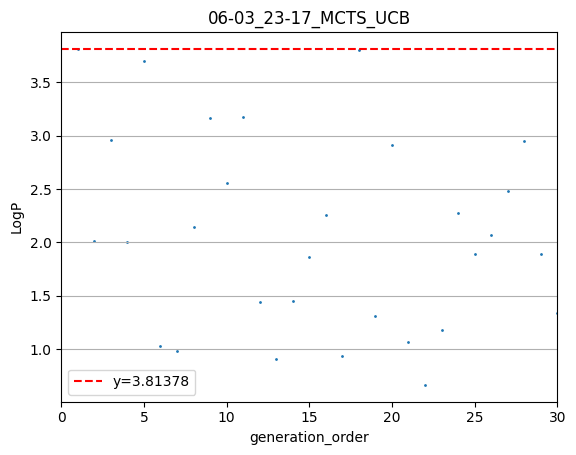

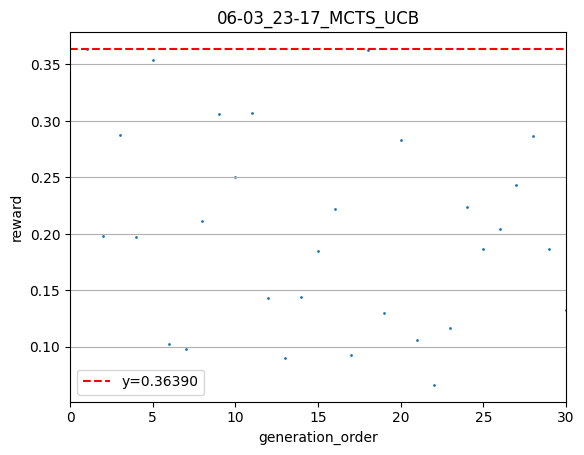

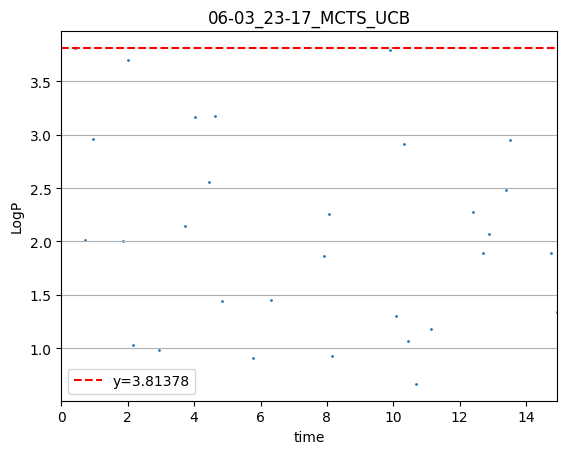

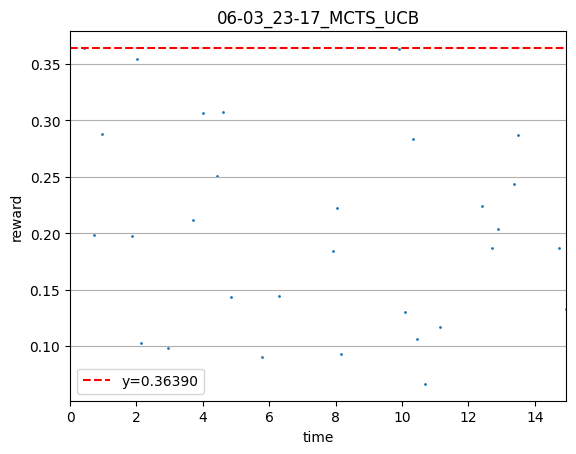

Search is completed.


In [31]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)